In [1]:
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal


from importlib import reload

reload(fp)
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import easygems.healpix as egh

import intake

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")

In [2]:
reload(orcestra)

<module 'orcestra' from '/home/m/m300609/.local/lib/python3.10/site-packages/orcestra/__init__.py'>

In [3]:
def find_ec_lon(lat_sel, ec_lons, ec_lats):
    return ec_lons[np.argmin(np.abs(ec_lats-lat_sel))]

In [19]:
date_time = datetime(2024, 8, 5, 12, 0, 0)
date_time_str = date_time.strftime('%Y-%m-%d')

flight_time = datetime(2024, 8, 11, 12, 0, 0)
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"
flight_index

'HALO-20240811a'

In [20]:
lon_min, lon_max, lat_min, lat_max = -65, -5, -10, 25

In [21]:
ds = cat.HIFS(refdate=date_time_str, reftime=date_time.hour).to_dask().pipe(egh.attach_coords)

In [22]:
track = orcestra.sat.SattrackLoader("EARTHCARE", "2024-08-05").get_track_for_day("2024-08-11")
track = track.sel(time=slice("2024-08-11 06:00", None))
ec_lons, ec_lats = track.lon.values, track.lat.values

In [39]:
lat_edge_south, lat_edge_north = 5.0, 11.5

In [40]:
radius = 100e3
band = "east"

airport = sal if band == "east" else bco

lat_north = 15.5 # 10th percentile 
lat_south = 2.0 # 5th percentile - 1°
north = LatLon(lat_north, find_ec_lon(lat_north, ec_lons, ec_lats), "north")

In [41]:
edge_north = LatLon(lat_edge_north, find_ec_lon(lat_edge_north, ec_lons, ec_lats), "edge_north")
edge_south = LatLon(lat_edge_south, find_ec_lon(lat_edge_south, ec_lons, ec_lats), "edge_south")

center = edge_south.towards(edge_north).assign_label("center")

south = LatLon(lat_south, find_ec_lon(lat_south, ec_lons, ec_lats), "south")

returnPoint = north if band == "east" else LatLon(bco.lat, -53.0, "")


leg_south = [
     airport,
     north,
     south
]

leg_circles = [
     IntoCircle(edge_south, radius, 360),
     IntoCircle(center, radius, 360),
     IntoCircle(edge_north, radius, 360),
]
    
leg_home = [
     north,
     airport
]

waypoints = leg_south + leg_circles + leg_home #

path = fp.expand_path(waypoints, dx=10e3)

#print(f"duration: {halo_flight_duration(path)}")

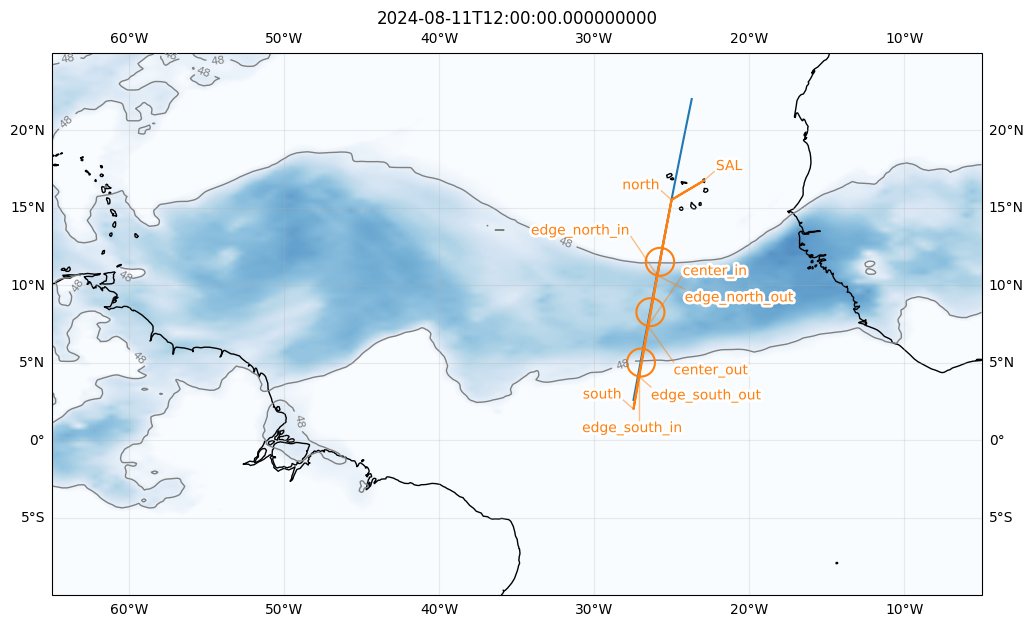

In [42]:
plt.figure(figsize = (12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)


cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time, levels = [48.0])
plt.title(cwv_flight_time.time.values)

plt.plot(ec_lons, ec_lats)
fp.plot_path(path, ax, color="C1")

In [27]:
find_ec_lon(1.5, ec_lons, ec_lats)

-27.4793

In [28]:
lats, lons, labels = [], [], []

for point in waypoints:
    
    if isinstance(point, IntoCircle):
        point = point.center
        
    lats.append(point.lat)
    lons.append(point.lon)
    labels.append(point.label)
    

In [29]:
import csv

# The name of your output file
flight_name = f"flight_data_{flight_index}.csv"

# Open a file in write mode
with open(flight_name, mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=';')

    # Write the header
    writer.writerow([flight_index])
    writer.writerow(["Index", "Location", "Lat (+-90)", "Lon (+-180)", "Comments"])

    # Write the data rows
    for index, (lat, lon, label) in enumerate(zip(lats, lons, labels)):
        writer.writerow([index, "", lat, lon, label])

print(f"CSV file '{flight_name}' created successfully.")

CSV file 'flight_data_HALO-20240811a.csv' created successfully.
